### The goal in this notebook is to show how to calculate the cost of tuning a LLM from OpenAI based on the size of the data for fine-tuning

In [1]:
import pandas as pd
medical_reports = pd.read_csv("reports.csv")
medical_reports.head()

,medical_specialty,report
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size...."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc..."


### Train-Test Split
The ***train*** is the data will be used for fine-tuning

In [2]:
grouped_data = medical_reports.groupby("medical_specialty").sample(110, random_state=42) # Sample 110 items from each class

val_test_data = grouped_data.groupby("medical_specialty").sample(10, random_state=42)  # sample 10 items from the above data
val = val_test_data.groupby("medical_specialty").head(5) # Take the first 5 of each class
test = val_test_data.groupby("medical_specialty").tail(5) # Take the last 5 of each class

train = grouped_data[~grouped_data.index.isin(val_test_data.index)] # Take the remaining ones for training

### Counting Number of Tokens
To calculate cost of training, we need to count the number of tokens in the training set

This is also important due to limitation of number of input tokens for models

We calculate the cost of training for OpenAI's cheapest model, babbage-002

For more information, check this [link](https://cookbook.openai.com/examples/how_to_count_tokens_with_tiktoken) from OpenAI

In [10]:
import tiktoken

def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string"""
    encoding = tiktoken.get_encoding("cl100k_base")  # encoding for currently all models
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [11]:
report_lengths = train['report'].apply(lambda x: num_tokens_from_string(x))
avg_report_length = report_lengths.mean()
min_report_length = report_lengths.min()
max_report_length = report_lengths.max()
report_length_sum = report_lengths.sum()

print(f"Average report length: {avg_report_length:.2f} tokens")
print(f"Minimum report length: {min_report_length} tokens")
print(f"Maximum report length: {max_report_length} tokens")
print(f"# The training dataset consists of: {report_length_sum} tokens")

Average report length: 674.79 tokens
Minimum report length: 14 tokens
Maximum report length: 3701 tokens
# The training dataset consists of: 337394 tokens


## Important Note!
Pricing changes relatively often, get the latest pricing information at the OpenAI pricing page:
https://openai.com/pricing 


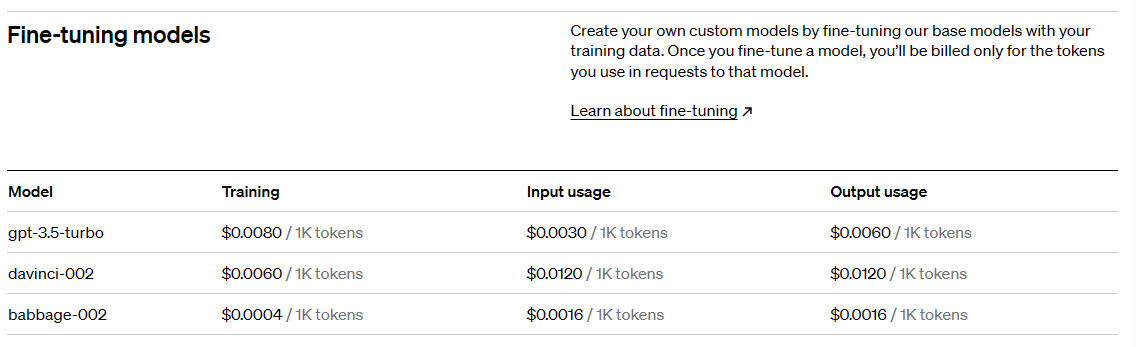

In [13]:
price_model = 0.0080   # Price for gpt-3.5-turbo for 1K tokens
model = "gpt-3.5-turbo"
price_per_epoch = (report_length_sum / 1000) * price_model 
print(f"Fine-tuning of {model} costs ~ ${price_per_epoch:.2f} per epoch") 

Fine-tuning of gpt-3.5-turbo costs ~ $2.70 per epoch
